In [7]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps import Place_net, Grid_net

In [8]:
z_min = 0
z_max = 20
place_num = 800
grid_num = 20
module_num = 7
map_num = 5
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=place_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 


Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=maps, place_index=place_index, neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi)
    Gird_module_list.append(Grid_cell)

conn_out = Grid_cell.conn_out
print(bm.mean(conn_out))

-1.6018749e-10


/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_33676/4065626475.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i].pcolormesh(grid_indices, sorted_maps, sorted_conn_mat, cmap='viridis')


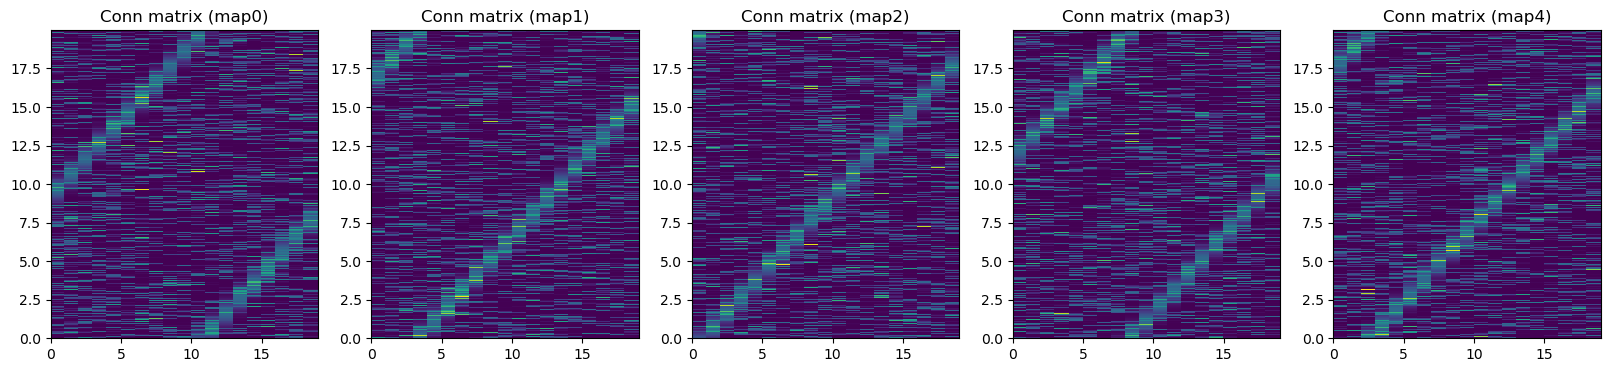

In [9]:
if map_num>1:
    _, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
    for i in range(map_num):
        grid_indices = np.arange(grid_num)
        # 获取排序后的索引
        sorted_indices = np.argsort(maps[i])
        sorted_maps = maps[i, sorted_indices]
        sorted_place_index = place_index[i, sorted_indices]
        sorted_conn_mat = conn_out[sorted_place_index,:]
        # 使用 pcolormesh 可视化矩阵
        ax[i].pcolormesh(grid_indices, sorted_maps, sorted_conn_mat, cmap='viridis')
        # ax[i].colorbar()  # 添加颜色条
        ax[i].set_title('Conn matrix (map'+str(i)+')')
else:
    grid_indices = np.arange(grid_num)
    # 获取排序后的索引
    sorted_indices = np.argsort(maps)
    sorted_maps = maps[sorted_indices]
    sorted_place_index = place_index[sorted_indices]
    sorted_conn_mat = conn_out[sorted_place_index,:]
    # 使用 pcolormesh 可视化矩阵
    plt.pcolormesh(grid_indices, sorted_maps, sorted_conn_mat, cmap='viridis')
    # ax[i].colorbar()  # 添加颜色条
    plt.title('Conn matrix')


In [10]:
map_index = 0
def run_net(indices, loc, input_stre):
    r_hpc = Place_cell.r
    output = bm.zeros(place_num,)
    for Grid_cell in Gird_module_list:
        Grid_cell.step_run(indices, r_hpc= r_hpc, loc=loc, input_stre=input_stre,map_index = map_index, )
        output += Grid_cell.output
    Place_cell.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre, input_g = output)
    place_r = Place_cell.r
        # output = bm.where(output>0, output, 0)
    return output, place_r

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(run_net, (indices, loc, input_stre), progress_bar = True)


  0%|          | 0/5000 [00:00<?, ?it/s]

-0.008154682


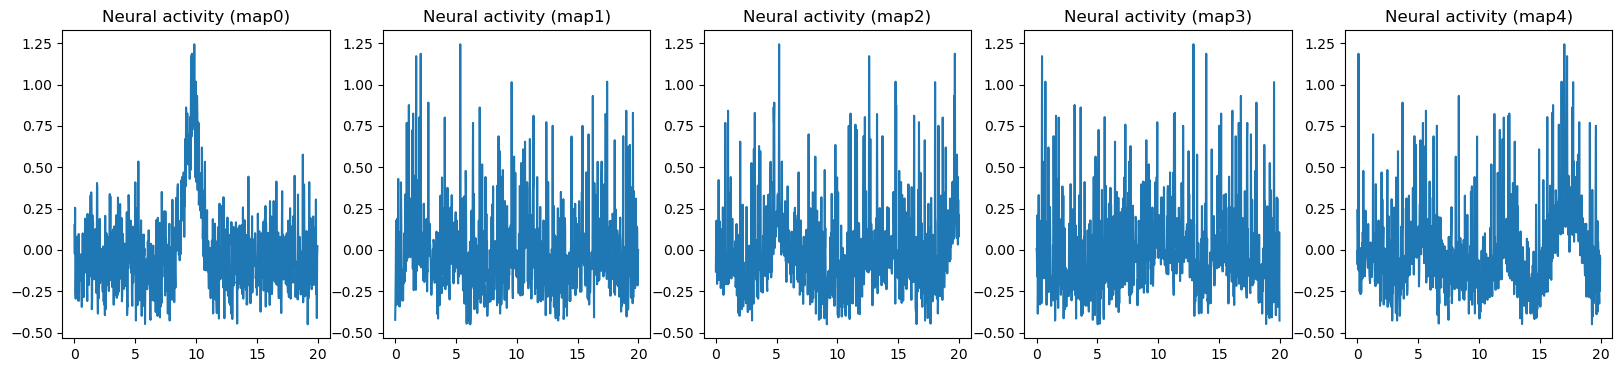

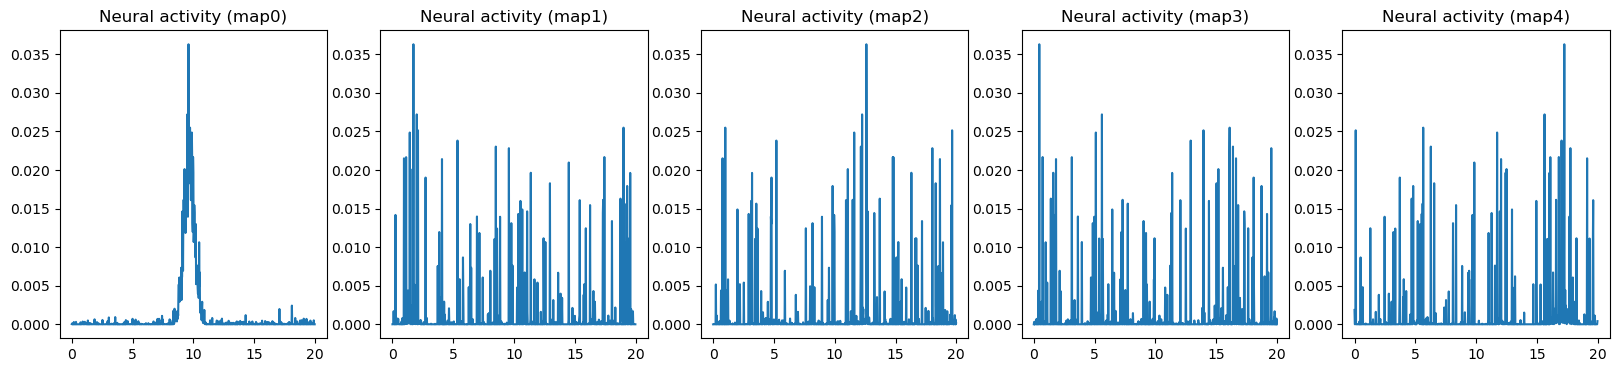

In [11]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(output[:, place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1,:])
    # ax[map_index].set_ylim([0, 5])
    ax[map_index].set_title('Neural activity (map'+str(map_index)+')')

_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(place_r[:, place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1,:])
    ax[map_index].set_title('Neural activity (map'+str(map_index)+')')
print(bm.mean(output[-1,:]))

0.7141421
0.1609928
0.15029283
0.12569396
0.14916298
[0.71414208 0.1609928  0.15029281 0.12569396 0.14916299]


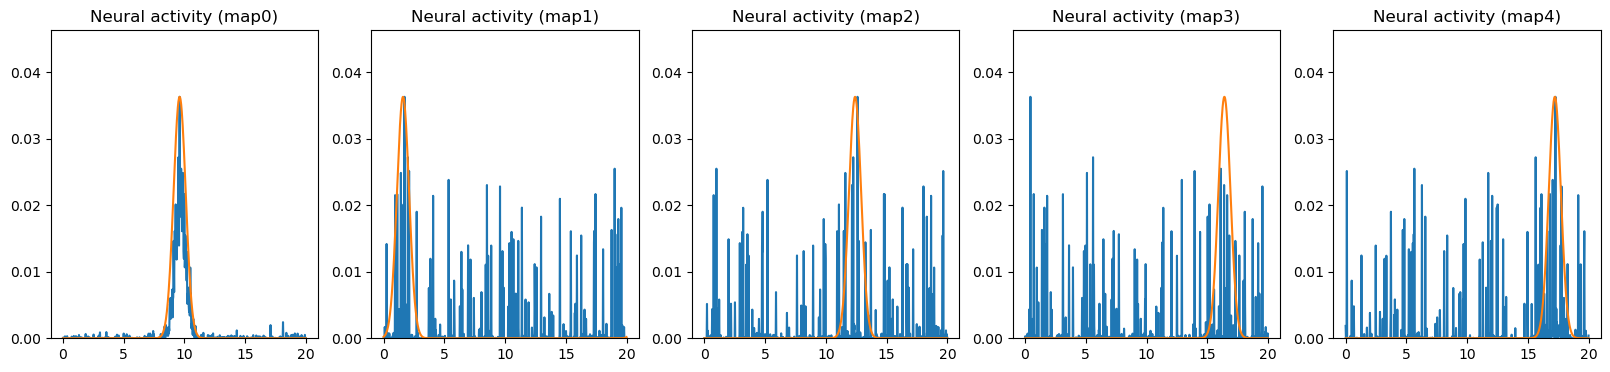

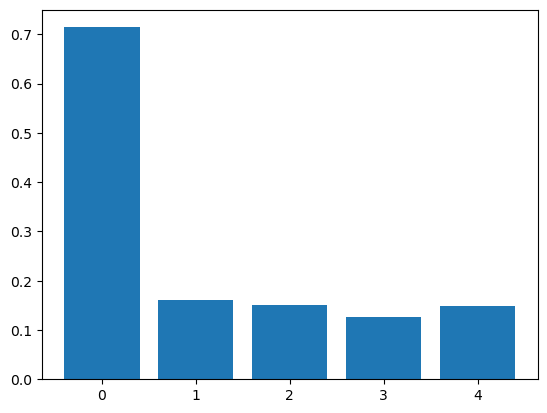

In [12]:
u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
    bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

_, ax = plt.subplots(1, map_num, figsize=(map_num * 4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[sorted_indices]
    bump = Place_cell.get_bump(map_index, max_score_pos[map_index])
    sorted_bump_normalize = bump[sorted_indices]
    bump_height = bm.max(sorted_u_place[:])
    sorted_bump = sorted_bump_normalize*bump_height

    print(bm.sum(sorted_u_place/bm.sum(sorted_u_place)*sorted_bump_normalize))
    ax[map_index].plot(sorted_maps, sorted_u_place)
    ax[map_index].plot(sorted_maps, sorted_bump)
    ax[map_index].set_title('Neural activity (map' + str(map_index) + ')')
    ax[map_index].set_ylim(0, np.max(u[:])+0.01)
print(bump_score)
plt.savefig('./figures/bump_activity.png')

plt.figure()
plt.bar(np.arange(map_num), bump_score)
plt.savefig('./figures/bump_score.png')